## Loading Imports

In [1]:
from copy import deepcopy
import os
from unicodedata import decimal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

# add imports for randomness
import time
import random

import sys

# Brevitas imports
import brevitas.nn as qnn
from brevitas.core.quant import QuantType
from brevitas.quant import Int32Bias
import torch.nn.functional as F

# For adaptive learning rate import
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split


## Imports from utils file for my defined noise functions
import sys
sys.path.append('C:/Users/ashin/source/repos/Cifar10_Pytorch_NoiseAnalysis/Cifar10_Pytorch_NoiseAnalysis/pynq-finn-FPGA/noise_weight_analysis/utils/')

from noise_functions import add_digital_noise, random_clust_mask

## Define Target Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cuda


## Load Dataset

Define the train and validation set sizes. Split dataset into train and validation sets.

Set the batch size. Create a dataloader for a training dataset with batch size of 1000.

### Data Augmentation

This code block applies data augmentation to the CIFAR-10 training dataset using transforms.RandomCrop and transforms.RandomHorizontalFlip. This randomly crops and flips the images in the dataset, which creates new variations of the original images. This technique is called data augmentation and can help prevent overfitting by increasing the diversity of the training dataset.

Additionally, this code block also normalizes the pixel values of both the training and validation datasets to have a mean of 0.5 and a standard deviation of 0.5 using transforms.Normalize.

Furthermore, the code block uses PyTorch DataLoader to create an iterator over the dataset that returns batches of data. This avoids the need for manual batch creation and helps to efficiently load and process the data.

Finally, this code block creates a DataLoader for the training and validation datasets with a batch size of 1000. This means that the model will process 1000 images at a time during training and validation, which can help to speed up the training process.

In [3]:
from torchvision import transforms

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply data augmentation to the training dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Use the validation transform for the validation dataset
val_set =torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)


a = next(iter(train_loader))
print(a[0].size())
print(len(train_set))

print("Samples in each set: train = %d, test = %s" % (len(train_set), len(train_loader))) 
print("Shape of one input sample: " +  str(train_set[0][0].shape))

## Data Loader
#
# Using PyTorch dataloader we can create a convenient iterator over the dataset that returns batches of data, rather than requiring manual batch creation.

# set batch size
batch_size = 1000

# Create a DataLoader for a training dataset with a batch size of 100
train_quantized_loader = DataLoader(train_set, batch_size=batch_size)
test_quantized_loader = DataLoader(val_set, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 32, 32])
50000
Samples in each set: train = 50000, test = 391
Shape of one input sample: torch.Size([3, 32, 32])


In [4]:
count = 0

print("\nDataset Shape:\n-------------------------")
for x, y in train_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break



Dataset Shape:
-------------------------
Input shape for 1 batch: torch.Size([128, 3, 32, 32])
Label shape for 1 batch: torch.Size([128])


## Define Model

There are 5 convolution layers and 2 Fully Connected QuantLinear Layers



In [5]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.quant_inp = qnn.QuantIdentity(bit_width=4, return_quant_tensor=True)

        self.layer1 = qnn.QuantConv2d(3, 32, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu1 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer2 = qnn.QuantConv2d(32, 32, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu2 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer3 = qnn.QuantConv2d(32, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu3 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer4 = qnn.QuantConv2d(64, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu4 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer5 = qnn.QuantConv2d(64, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu5 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.fc1 = qnn.QuantLinear(64 * 8 * 8, 512, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu6 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.fc2 = qnn.QuantLinear(512, 10, bias=True, weight_bit_width=4, bias_quant=Int32Bias)

    def forward(self, x):
        x = self.quant_inp(x)
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = F.max_pool2d(x, 2)

        x = self.relu3(self.layer3(x))
        x = self.relu4(self.layer4(x))
        x = F.max_pool2d(x, 2)

        x = self.relu5(self.layer5(x))

        x = x.view(x.size(0), -1)

        x = self.relu6(self.fc1(x))
        x = self.fc2(x)

        return x

In [6]:
# Import testing
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import precision_recall_fscore_support

# Initialize the model, optimizer, and criterion
model = CIFAR10CNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
criterion = nn.CrossEntropyLoss()

num_epochs = 80
best_test_accuracy = 0
patience = 4
no_improvement_counter = 0

print(model)

CIFAR10CNN(
  (quant_inp): QuantIdentity(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ParameterFromRuntimeStatsScaling(
            (stats_input_view_shape_impl): OverTensorView()
            (stats): _Stats(
              (stats_impl): AbsPercentile()
            )
            (restrict_scaling): _RestrictValue(
              (restrict_value_impl): FloatRestrictValue()
            )
            (clamp_scaling): _ClampValue(
              (clamp_min_

## Train and Test

In [7]:
for epoch in range(num_epochs):

    # training phase
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
    
    # Initialize the validation loss
    val_loss = 0
    
    # testing phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # accumulate the validation loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
        val_loss /= len(val_loader)  # calculate the average validation loss
    
        # Update the learning rate using the validation loss
        scheduler.step(val_loss)

        test_accuracy = 100 * correct / total
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
        
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            
        if no_improvement_counter >= patience:
            print("Early stopping")
            break

        print('Epoch [{}/{}], Test Accuracy: {:.2f}%, Precision: {:.2f}, Recall: {:.2f}, F1 score: {:.2f}'.format(epoch+1, num_epochs, test_accuracy, precision, recall, f1))


Epoch [1/80], Step [100/391], Loss: 1.8353
Epoch [1/80], Step [200/391], Loss: 1.6892
Epoch [1/80], Step [300/391], Loss: 1.4895
Epoch [1/80], Test Accuracy: 48.35%, Precision: 0.50, Recall: 0.48, F1 score: 0.47
Epoch [2/80], Step [100/391], Loss: 1.3974
Epoch [2/80], Step [200/391], Loss: 1.3293
Epoch [2/80], Step [300/391], Loss: 1.0691
Epoch [2/80], Test Accuracy: 58.50%, Precision: 0.58, Recall: 0.58, F1 score: 0.58
Epoch [3/80], Step [100/391], Loss: 1.4546
Epoch [3/80], Step [200/391], Loss: 1.4877
Epoch [3/80], Step [300/391], Loss: 1.2133
Epoch [3/80], Test Accuracy: 63.14%, Precision: 0.63, Recall: 0.63, F1 score: 0.63
Epoch [4/80], Step [100/391], Loss: 1.1304
Epoch [4/80], Step [200/391], Loss: 0.9296
Epoch [4/80], Step [300/391], Loss: 0.9632
Epoch [4/80], Test Accuracy: 65.24%, Precision: 0.66, Recall: 0.65, F1 score: 0.65
Epoch [5/80], Step [100/391], Loss: 1.0766
Epoch [5/80], Step [200/391], Loss: 0.9853
Epoch [5/80], Step [300/391], Loss: 1.1555
Epoch [5/80], Test Accu

In [1]:
# Print the best test accuracy
print("The final best test accuracy is: {:.2f}% at Epoch: {}".format(best_test_accuracy, epoch + 1))

NameError: name 'best_test_accuracy' is not defined

TypeError: 'int' object is not subscriptable

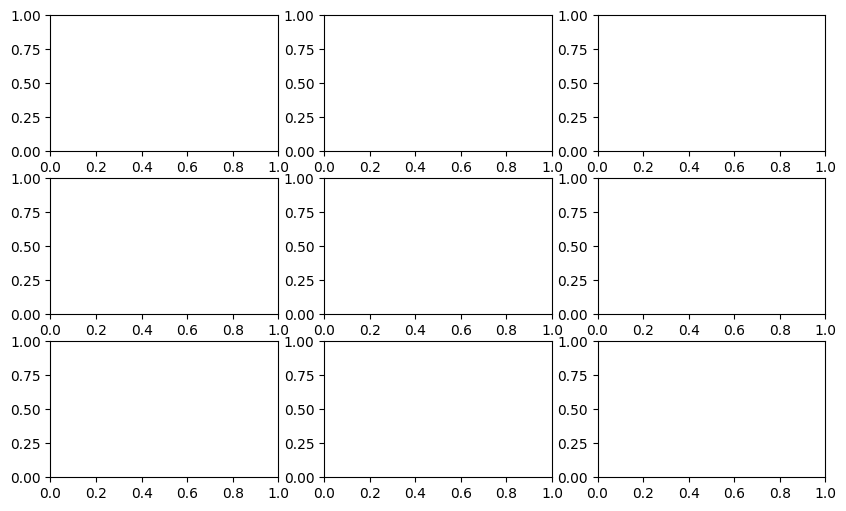

In [9]:
# Testing
N = model.layer1.weight.data.size(-1)

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 6))

# Generate masks with different values for P
P_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75, 1]
gamma_values = [1e-3, 0.1, 0.1, 0.5, 0.75, 0.99, 1, 1.5, 2]

# Loop over subplots and generate mask for each value of P
for i, ax in enumerate(axs.flatten()):
    P = P_values[i]
    G = gamma_values[i]
    mask = random_clust_mask(64, P, G)
    ax.imshow(mask, cmap='gray')
    ax.set_title("Probability = {}, Gamma = {}".format(P, G))

# Adjust spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()

In [10]:
random.seed(time.time())

# Testing function with a sweep from 1e-8 to 1e-3
matrix = np.random.rand(3, 3) * 2 - 1

"""
for i in range(6):
    ber = 10 ** (-8+i)
    noisy_matrix = add_digital_noise(matrix, ber)
    print(f"BER = {ber:.1e}:\n{noisy_matrix}\n")
"""



'\nfor i in range(6):\n    ber = 10 ** (-8+i)\n    noisy_matrix = add_digital_noise(matrix, ber)\n    print(f"BER = {ber:.1e}:\n{noisy_matrix}\n")\n'

In [11]:
# Testing Noise

trained_state_dict = model.state_dict()

def test(model, test_loader):
    # testing phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


def random_clust_mask(weight_shape, P, gamma):

    # Generate random NxN matrix with values between 0 and 1
    N = weight_shape[-1]
    matrix = np.random.rand(N, N)

    # Compute 2D FFT
    fft_result = np.fft.fft2(matrix)

    # 1D Frequency Vector with N bins
    f = np.fft.fftfreq(N, d=1.0/weight_shape[-1])
    f_x, f_y = np.meshgrid(f, f)
    f_x[0, 0] = 1e-6
    f_y[0, 0] = 1e-6

    # Create a 2D filter in frequency space that varies inversely with freq over f
    # Gamma controls the falloff rate
    filter_2D = 1/(np.sqrt(f_x**2 + f_y**2))**gamma

    # Mult the 2D elementwise by the filter
    filtered_fft = fft_result * filter_2D

    # 2D inverse FFT of the filtered result
    ifft_result = np.fft.ifft2(filtered_fft)
    ifft_result = np.real(ifft_result)

    # Set the threshold T equal the the max value in IFFT
    T = ifft_result.max()

    # Init empty bool mask with same dims as ifft
    mask = np.zeros_like(ifft_result, dtype=bool)

    decrement_step = 0.01

    # Repeat until frac of nonzero values in the mask is greater than or equal to P
    while True:
        mask = ifft_result > T

        current_fraction = np.count_nonzero(mask) / (N * N)

        if current_fraction >= P:
            break

        T -= decrement_step

    # Return tensor with the same shape as the input tensor
    mask = np.tile(mask, (weight_shape[0], weight_shape[1], 1, 1))
    return torch.tensor(mask, dtype=torch.float)


def add_mask_to_model_brevitas(model, layer_names, p, gamma, num_perturbations):

    modified_models = []

    for _ in range(num_perturbations):

        modified_model = deepcopy(model)

        for layer_name in layer_names:

            layer = getattr(modified_model, layer_name)

            with torch.no_grad():

                # get weights and biases of the tensors
                weight = layer.weight.cpu().detach().numpy()
                bias = layer.bias.cpu().detach().numpy() if layer.bias is not None else None

                # get number of output channels of layer
                out_channels = layer.out_channels

                # generate mask with correct shape
                mask = random_clust_mask(weight.shape, p, gamma)

                # convert weight tensor to PyTorch tensor
                weight_tensor = torch.tensor(weight, dtype=torch.float)

                # apply mask to the whole weight tensor
                weight_tensor *= torch.tensor(mask, dtype=torch.float)

                # create new weight parameter and assign to layer
                noised_weight = torch.nn.Parameter(weight_tensor, requires_grad=False)
                layer.weight = noised_weight

        modified_models.append(modified_model)

    return modified_models


In [16]:
pvals = [0.1, 0.5, 1.0]
gammavals = [0.1, 0.5, 1.0]

from noise_functions import test, add_mask_to_model_brevitas, random_clust_mask

def test(model, test_loader, device):
    # testing phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

layers = ['layer1']

num_perturbations = 5

print("\nTesting Perturbations for Layer 1:")

for p in range(len(pvals)):
    
    noisy_models = add_mask_to_model_brevitas(model, layers, pvals[p], gammavals[p], num_perturbations)
    
    accuracies = []
    
    for noisy_model in noisy_models:
        
        noisy_model.to(device)
        accuracies.append(test(noisy_model, test_quantized_loader, device))
        
    avg_accuracy = sum(accuracies) / len(accuracies)
    
    print("P Value: ", pvals[p], ", Gamma Value: ", gammavals[p], " Average Accuracy: ", avg_accuracy, "%")


Testing Perturbations for Layer 1:
P Value:  0.1 , Gamma Value:  0.1  Average Accuracy:  12.45 %
P Value:  0.5 , Gamma Value:  0.5  Average Accuracy:  44.732 %
P Value:  1.0 , Gamma Value:  1.0  Average Accuracy:  81.18 %


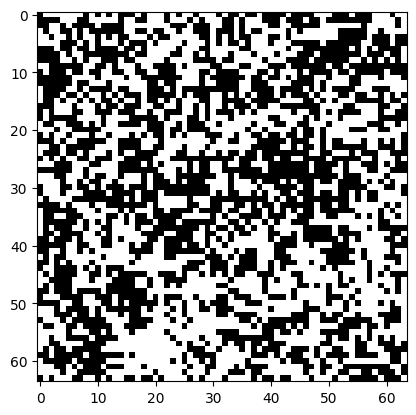

In [11]:
def random_clust_mask(weight_shape, P, gamma):

    # Generate random NxN matrix with values between 0 and 1
    N = weight_shape[-1]
    matrix = np.random.rand(N, N)

    # Compute 2D FFT
    fft_result = np.fft.fft2(matrix)

    # 1D Frequency Vector with N bins
    f = np.fft.fftfreq(N, d=1.0/weight_shape[-1])
    f_x, f_y = np.meshgrid(f, f)
    f_x[0, 0] = 1e-6
    f_y[0, 0] = 1e-6

    # Create a 2D filter in frequency space that varies inversely with freq over f
    # Gamma controls the falloff rate
    filter_2D = 1/(np.sqrt(f_x**2 + f_y**2))**gamma

    # Mult the 2D elementwise by the filter
    filtered_fft = fft_result * filter_2D

    # 2D inverse FFT of the filtered result
    ifft_result = np.fft.ifft2(filtered_fft)
    ifft_result = np.real(ifft_result)

    # Set the threshold T equal the the max value in IFFT
    T = ifft_result.max()

    # Init empty bool mask with same dims as ifft
    mask = np.zeros_like(ifft_result, dtype=bool)

    decrement_step = 0.01

    # Repeat until frac of nonzero values in the mask is greater than or equal to P
    while True:
        mask = ifft_result > T

        current_fraction = np.count_nonzero(mask) / (N * N)

        if current_fraction >= P:
            break

        T -= decrement_step

    # Return tensor with the same shape as the input tensor
    mask = np.tile(mask, (weight_shape[0], weight_shape[1], 1, 1))
    return torch.tensor(mask, dtype=torch.float)

weight = torch.randn((1, 1, 64, 64))

mask = random_clust_mask(weight.shape, 0.5, 0.5)

plt.imshow(mask[0, 0], cmap='gray')
plt.show()

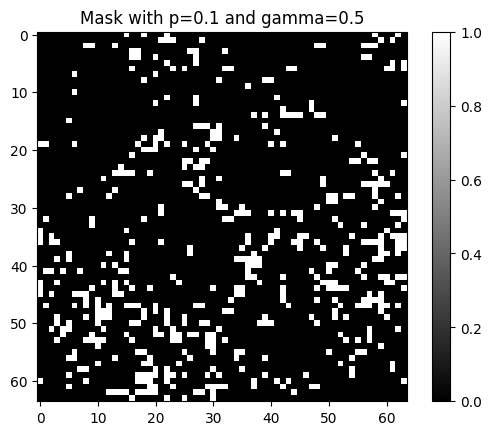

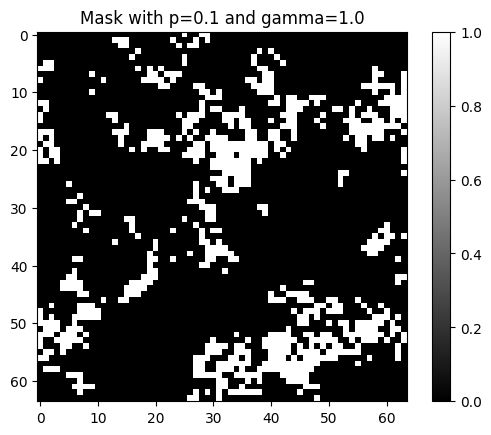

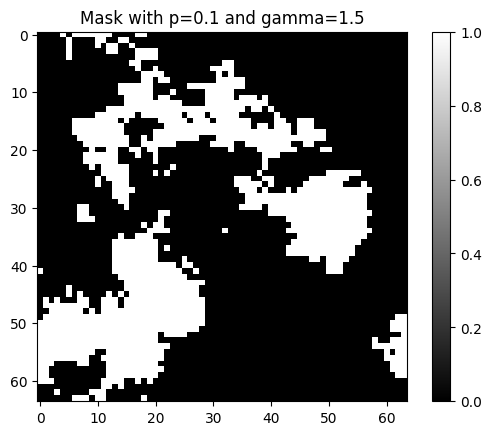

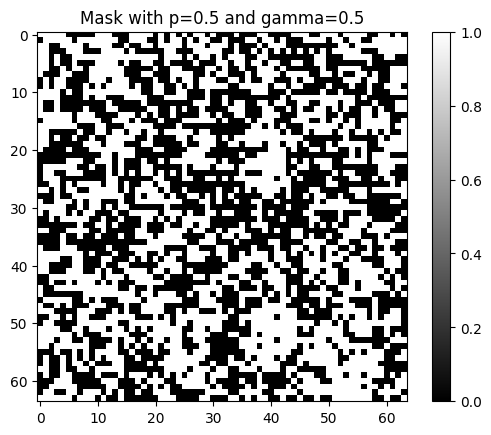

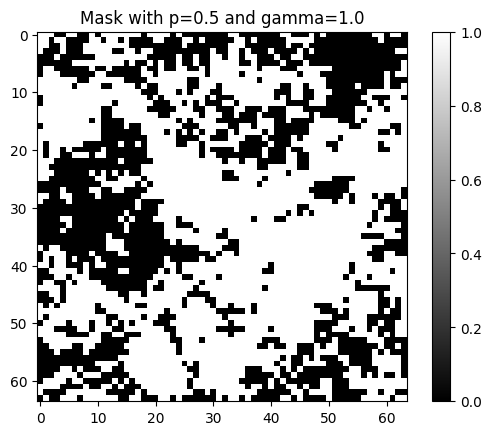

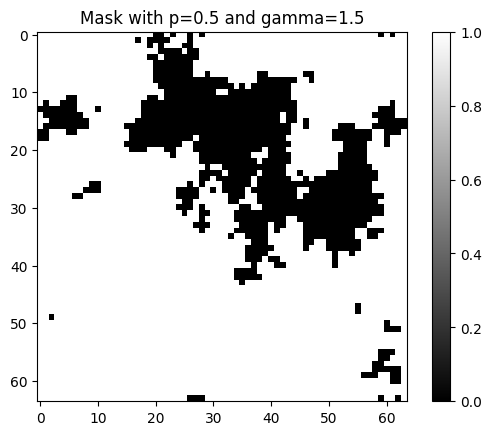

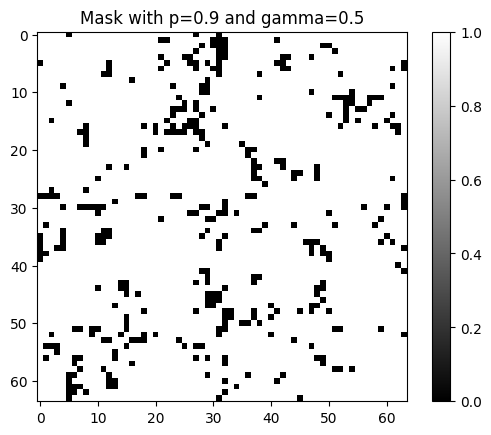

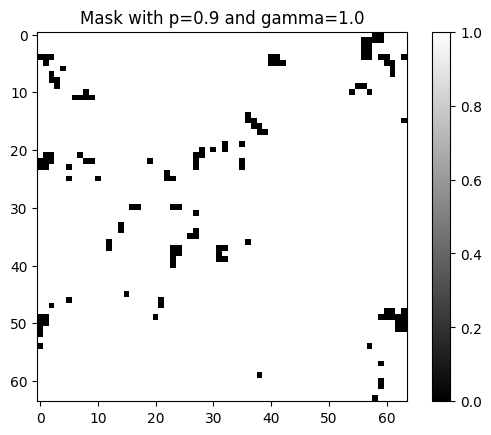

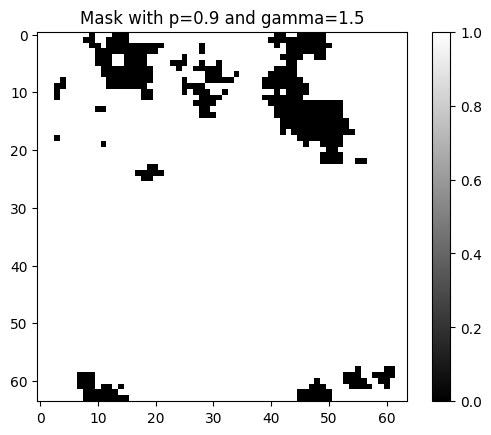

In [11]:
import torch
model = torch.load("best_model.pth")

def add_mask_to_model_brevitas(model, layer_names, p, gamma, num_perturbations):

    modified_models = []

    for _ in range(num_perturbations):

        modified_model = deepcopy(model)

        for layer_name in layer_names:

            layer = getattr(modified_model, layer_name)

            with torch.no_grad():

                # get weight of the tensors
                weight = layer.weight.cpu().detach().numpy()

                # generate mask with correct shape
                mask = random_clust_mask(weight.shape, p, gamma)
                
                print(np.sum(mask.numpy())/np.size(mask.numpy()))

                # convert weight tensor to PyTorch tensor
                weight_tensor = torch.tensor(weight, dtype=torch.float)

                # apply mask to the whole weight tensor
                weight_tensor *= torch.tensor(mask, dtype=torch.float)

                # create new weight parameter and assign to layer
                noised_weight = torch.nn.Parameter(weight_tensor, requires_grad=False)
                layer.weight = noised_weight

        modified_models.append(modified_model)

    return modified_models

def visualize_masks(p_values, gamma_values, weight_shape):
    for p in p_values:
        for gamma in gamma_values:
            mask = random_clust_mask(weight_shape, p, gamma)
            plt.imshow(mask[0, 0], cmap='gray')
            plt.title(f'Mask with p={p} and gamma={gamma}')
            plt.colorbar()
            plt.show()

# Example usage:
weight_shape = (1, 1, 64, 64)  # Adjust the shape to match the shape of the weights in your model
p_values = [0.1, 0.5, 0.9]
gamma_values = [0.5, 1.0, 1.5]
visualize_masks(p_values, gamma_values, weight_shape)

In [14]:
def add_mask_to_model_brevitas(model, layer_names, p, gamma, num_perturbations, print_weights=False):

    modified_models = []

    for _ in range(num_perturbations):

        modified_model = deepcopy(model)

        for layer_name in layer_names:

            layer = getattr(modified_model, layer_name)

            with torch.no_grad():

                # get weights of the tensors
                weight_tensor = layer.weight.cpu().clone().detach()

                # generate mask with correct shape
                mask = random_clust_mask(weight_tensor.shape, p, gamma)

                if print_weights:
                    print("Weights before masking:")
                    print(weight_tensor)

                # apply mask to the whole weight tensor
                mask_tensor = torch.tensor(mask, dtype=torch.float)
                weight_tensor *= mask_tensor

                if print_weights:
                    print("Weights after masking:")
                    print(weight_tensor)

                # create new weight parameter and assign to layer
                noised_weight = torch.nn.Parameter(weight_tensor, requires_grad=False)
                layer.weight = noised_weight

        modified_models.append(modified_model)

    return modified_models


In [15]:
pvals = [0.1, 0.5, 1.0]
gammavals = [0.1, 0.5, 1.0]


def test(model, test_loader, device):
    # testing phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

layers = ['layer1']

num_perturbations = 5

print("\nTesting Perturbations for Layer 1:")

for p in range(len(pvals)):
    
    noisy_models = add_mask_to_model_brevitas(model, layers, pvals[p], gammavals[p], num_perturbations)
    
    accuracies = []
    
    for noisy_model in noisy_models:
        
        noisy_model.to(device)
        accuracies.append(test(noisy_model, test_quantized_loader, device))
        
    avg_accuracy = sum(accuracies) / len(accuracies)
    
    print("P Value: ", pvals[p], ", Gamma Value: ", gammavals[p], " Average Accuracy: ", avg_accuracy, "%")


Testing Perturbations for Layer 1:


AttributeError: 'collections.OrderedDict' object has no attribute 'layer1'

In [ ]:
def mask_noise_plots_brevitas(num_perturbations, layer_names, p_values, gamma_values, model, device):
    if not os.path.exists("noise_plots_brevitas/mask/"):
        os.makedirs("noise_plots_brevitas/mask")
        
    plt.style.use('default')
    
    # Create a list to store the test accuracies for all layers
    all_test_accs = []
    
    # Loop over each layer
    for layer in layer_names:
        # Initialize a list to store the test accuracies for this layer
        test_accs = []
        
        # Iterate over p_values and gamma_values
        for p in p_values:
            for gamma in gamma_values:
                
                # Add noise to the model for the defined layer only
                noisy_models = add_mask_to_model_brevitas(
                    model, [layer], p, gamma, num_perturbations)
                
                accuracies = []
                
                # Test the accuracy of each noisy model and append the result to the accuracies list
                for noisy_model in noisy_models:
                    # Move the model back to the target device
                    noisy_model.to(device)
                    accuracies.append(test(noisy_model, test_quantized_loader, device))
                
                # Calculate the average accuracy and print the result
                avg_accuracy = sum(accuracies) / len(accuracies)
                test_accs.append(avg_accuracy)
                print("Layer: {}, p: {}, gamma: {}, Average Accuracy: {}%".format(
                    layer, p, gamma, avg_accuracy))
        
        # Store the test accuracies for this layer in the all_test_accs list
        all_test_accs.append(test_accs)
    
    # Define the grid for p_values and gamma_values
    p_grid, gamma_grid = np.meshgrid(p_values, gamma_values)
    
    for i, layer in enumerate(layer_names):
        # Reshape test_accs list into a matrix
        test_accs_matrix = np.reshape(all_test_accs[i], (len(p_values), len(gamma_values)))
    
        # Create heatmap for the current layer
        plt.figure()
        plt.imshow(test_accs_matrix, cmap='viridis', origin='lower',
                   extent=(p_values[0], p_values[-1], gamma_values[0], gamma_values[-1]),
                   aspect='auto')
        plt.colorbar(label='Test Accuracy')
        plt.xlabel('P value')
        plt.ylabel('Gamma value')
        plt.title(f'Effect of Mask on Test Accuracy for {layer}')
        plt.savefig(f"noise_plots_brevitas/mask/{layer}.png")
        plt.clf()
    
    # Compute the average test accuracy across all layers for each p and gamma value
    avg_test_accs = np.mean(all_test_accs, axis=0)
    avg_test_accs_matrix = np.reshape(avg_test_accs, (len(p_values), len(gamma_values)))
    
    # Create heatmap for the average test accuracy
    plt.figure()
    plt.imshow(avg_test_accs_matrix, cmap='viridis', origin='lower',
               extent=(p_values[0], p_values[-1], gamma_values[0], gamma_values[-1]),
               aspect='auto')
    plt.colorbar(label='Test Accuracy')
    plt.xlabel('P value')
    plt.ylabel('Gamma Value')
    plt.title('Effect of Mask on Test Accuracy (Average)')
    plt.savefig("noise_plots_brevitas/mask/average.png")
    plt.show()
    plt.clf()
    
    
    # Begin Scatter Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the grid for p_values and gamma_values
    p_grid, gamma_grid = np.meshgrid(p_values, gamma_values)
    
    for i, layer in enumerate(layer_names):
        # Reshape test_accs list into a matrix
        test_accs_matrix = np.reshape(all_test_accs[i], (len(p_values), len(gamma_values)))
        
        # Flatten the matrices
        pvals_mesh = p_grid.flatten()
        gammavals_mesh = gamma_grid.flatten()
        layer_indices_mesh = np.full_like(pvals_mesh, i)  # create an array of layer indices
        
        # Scatter plot with layer indices, pvals, gammavals, and corresponding test accuracies
        c_array = np.array(test_accs_matrix).flatten()
        scatter = ax.scatter(layer_indices_mesh, pvals_mesh, gammavals_mesh, c=c_array, cmap='viridis', marker='o', s=60)
    
    # Customize the plot
    ax.set_xlabel('Layer index')
    ax.set_ylabel('P value')
    ax.set_zlabel('Gamma value')
    ax.set_xticks(np.arange(len(layer_names)))
    ax.set_xticklabels(layer_names)
    
    # Add color bar to the plot
    cbar = fig.colorbar(scatter, ax=ax, label='Test Accuracy')
    
    # Save and show the plot
    plt.savefig("noise_plots_brevitas/mask/scatter_plot.png")
    plt.show()


In [23]:
def add_digital_noise_to_model_brevitas(model, layer_names, ber, num_perturbations):
    
    modified_models = []
    
    for _ in range(num_perturbations):
        
        modified_model = deepcopy(model)
        
        for layer_name in layer_names:
            
            layer = getattr(modified_model, layer_name)
            
            with torch.no_grad():
                
                weight = layer.weight.cpu().detach().numpy()
                noisy_weight = add_digital_noise(weight, ber)
                
                
                layer.weight = torch.nn.Parameter(torch.tensor(noisy_weight, dtype=torch.float))
                
        modified_models.append(modified_model)
        
    return modified_models


# Test add digital noise with BER

bers = [1e-6, 1e-5, 1e-4, 1e-3, 0.005, 0.01, 0.05, 0.1]

layers = ['layer1']

num_perturbations = 5

print("\nTesting Perturbations for Layer 1 with Digital Noise:")

for b in range(len(bers)):
    
    noisy_models = add_digital_noise_to_model_brevitas(model, layers, bers[b], num_perturbations)
    
    accuracies = []
    
    for noisy_model in noisy_models:
        
        noisy_model.to(device)
        accuracies.append(test(noisy_model, test_quantized_loader, device))
        
    avg_accuracy = sum(accuracies) / len(accuracies)
    
    print("Ber: ", bers[b], " Average Accuracy: ", avg_accuracy, "%")


Testing Perturbations for Layer 1 with Digital Noise:
Ber:  1e-06  Average Accuracy:  81.18 %
Ber:  1e-05  Average Accuracy:  81.18 %
Ber:  0.0001  Average Accuracy:  80.788 %
Ber:  0.001  Average Accuracy:  79.91 %
Ber:  0.005  Average Accuracy:  76.53 %
Ber:  0.01  Average Accuracy:  73.882 %
Ber:  0.05  Average Accuracy:  55.05799999999999 %
Ber:  0.1  Average Accuracy:  48.436 %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# update number of perturbations
num_perturbations = 1

# Define layer names
layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'fc1', 'fc2']
if not os.path.exists("noise_plots_brevitas/mask/"):
    os.makedirs("noise_plots_brevitas/mask")
plt.style.use('default')

# Define p_values and gamma_values
p_vals = np.linspace(1e-3, 0.4, 15)
gamma_vals = np.linspace(1e-3, 0.99, 5)

# Create a list to store the test accuracies for all layers
all_test_accs = []

# Loop over each layer
for layer in layer_names:
    # Initialize a list to store the test accuracies for this layer
    test_accs = []
    
    # Iterate over p_values and gamma_values
    for p in p_values:
        for gamma in gamma_values:
            
            # Add noise to the model for the defined layer only
            noisy_models = add_mask_to_model_brevitas(
                model, [layer], p, gamma, num_perturbations)
            accuracies = []
            
            # Test the accuracy of each noisy model and append the result to the accuracies list
            for noisy_model in noisy_models:
                # Move the model back to the target device
                noisy_model.to(device)
                accuracies.append(test(noisy_model, test_quantized_loader, device))
            
            # Calculate the average accuracy and print the result
            avg_accuracy = sum(accuracies) / len(accuracies)
            test_accs.append(avg_accuracy)
            print("Layer: {}, p: {}, gamma: {}, Average Accuracy: {}%".format(
                layer, p, gamma, avg_accuracy))
    
    # Store the test accuracies for this layer in the all_test_accs list
    all_test_accs.append(test_accs)

# Define the grid for p_values and gamma_values
p_grid, gamma_grid = np.meshgrid(p_values, gamma_values)

for i, layer in enumerate(layer_names):
    # Reshape test_accs list into a matrix
    test_accs_matrix = np.reshape(all_test_accs[i], (len(p_values), len(gamma_values)))

    # Create heatmap for the current layer
    plt.figure()
    plt.imshow(test_accs_matrix, cmap='viridis', origin='lower',
               extent=(p_values[0], p_values[-1], gamma_values[0], gamma_values[-1]),
               aspect='auto')
    plt.colorbar(label='Test Accuracy')
    plt.xlabel('p value')
    plt.ylabel('gamma value')
    plt.title(f'Effect of Mask on Test Accuracy for {layer}')
    plt.savefig(f"noise_plots_brevitas/mask/{layer}.png")
    plt.clf()

# Compute the average test accuracy across all layers for each p and gamma value
avg_test_accs = np.mean(all_test_accs, axis=0)
avg_test_accs_matrix = np.reshape(avg_test_accs, (len(p_values), len(gamma_values)))

# Create heatmap for the average test accuracy
plt.figure()
plt.imshow(avg_test_accs_matrix, cmap='viridis', origin='lower',
           extent=(p_values[0], p_values[-1], gamma_values[0], gamma_values[-1]),
           aspect='auto')
plt.colorbar(label='Test Accuracy')
plt.xlabel('P value')
plt.ylabel('Gamma Value')
plt.title('Effect of Mask on Test Accuracy (Average)')
plt.savefig("noise_plots_brevitas/mask/average.png")
plt.show()
plt.clf()


NameError: name 'p_values' is not defined

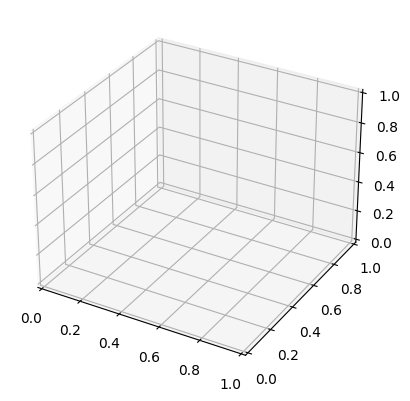

In [12]:
## Create Scatter Plot

# After the loop
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the grid for p_values and gamma_values
p_grid, gamma_grid = np.meshgrid(p_values, gamma_values)

for i, layer in enumerate(layer_names):
    # Reshape test_accs list into a matrix
    test_accs_matrix = np.reshape(all_test_accs[i], (len(p_values), len(gamma_values)))
    
    # Flatten the matrices
    pvals_mesh = p_grid.flatten()
    gammavals_mesh = gamma_grid.flatten()
    layer_indices_mesh = np.full_like(pvals_mesh, i)  # create an array of layer indices
    
    # Scatter plot with layer indices, pvals, gammavals, and corresponding test accuracies
    c_array = np.array(test_accs_matrix).flatten()
    scatter = ax.scatter(layer_indices_mesh, pvals_mesh, gammavals_mesh, c=c_array, cmap='viridis', marker='o', s=60)

# Customize the plot
ax.set_xlabel('Layer index')
ax.set_ylabel('P value')
ax.set_zlabel('Gamma value')
ax.set_xticks(np.arange(len(layer_names)))
ax.set_xticklabels(layer_names)

# Add color bar to the plot
cbar = fig.colorbar(scatter, ax=ax, label='Test Accuracy')

# Save and show the plot
plt.savefig("noise_plots_brevitas/mask/scatter_plot.png")
plt.show()

BER Value: 1e-06	Average Accuracy: 81.18
BER Value: 1e-05	Average Accuracy: 81.18
BER Value: 0.0001	Average Accuracy: 81.18
BER Value: 0.001	Average Accuracy: 79.77
BER Value: 0.01	Average Accuracy: 76.04
BER Value: 0.1	Average Accuracy: 48.45
Done with Plot layer1
BER Value: 1e-06	Average Accuracy: 81.18
BER Value: 1e-05	Average Accuracy: 81.18
BER Value: 0.0001	Average Accuracy: 81.18
BER Value: 0.001	Average Accuracy: 80.8
BER Value: 0.01	Average Accuracy: 70.84
BER Value: 0.1	Average Accuracy: 42.24
Done with Plot layer2
BER Value: 1e-06	Average Accuracy: 81.18
BER Value: 1e-05	Average Accuracy: 81.18
BER Value: 0.0001	Average Accuracy: 79.95
BER Value: 0.001	Average Accuracy: 79.03
BER Value: 0.01	Average Accuracy: 77.15
BER Value: 0.1	Average Accuracy: 54.85
Done with Plot layer3
BER Value: 1e-06	Average Accuracy: 81.18
BER Value: 1e-05	Average Accuracy: 81.12
BER Value: 0.0001	Average Accuracy: 80.62
BER Value: 0.001	Average Accuracy: 79.97
BER Value: 0.01	Average Accuracy: 76.8

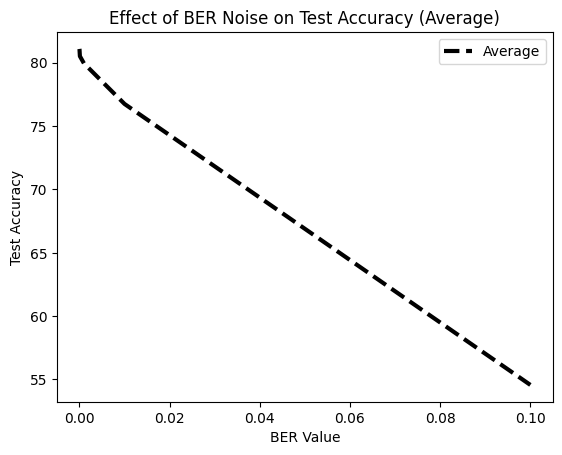

<Figure size 640x480 with 0 Axes>

In [58]:
# Function to Plot BER Noise Function
num_perturbations = 1

layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'fc1', 'fc2']

if not os.path.exists("noise_plots_brevitas/ber_noise/"):
    os.makedirs("noise_plots_brevitas/ber_noise/")
    
plt.style.use('default')

ber_vector = [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1]

all_test_accs = []

for layer in layer_names:
    test_accs = []
    
    for ber in ber_vector:
        noisy_models = add_digital_noise_to_model_brevitas(model, [layer], ber, num_perturbations)
        
        accuracies = []
        
        for noisy_model in noisy_models:
            
            noisy_model.to(device)
            accuracies.append(test(noisy_model, test_quantized_loader, device))
            
        avg_accuracy = sum(accuracies) / len(accuracies)
        
        test_accs.append(avg_accuracy)
        
        print("BER Value: {}\tAverage Accuracy: {}".format(ber, avg_accuracy))
        
    all_test_accs.append(test_accs)
    
    plt.plot(ber_vector, test_accs,
             label='{} Accuracy at Different Perturbation Levels'.format(layer))
    
    plt.xlabel('Standard Deviation')
    plt.ylabel('Test Accuracy')
    plt.title('Effect of Noise on Test Accuracy')
    plt.legend()
    plt.savefig("noise_plots_brevitas/ber_noise/{}.png".format(layer))
    plt.clf()
    print('Done with Plot {}'.format(layer))
    
avg_test_accs = [sum(x) / len(x) for x in zip(*all_test_accs)]

plt.plot(ber_vector, avg_test_accs, label='Average',
         linewidth=3, linestyle='--', color="black")

plt.xlabel('BER Value')

plt.ylabel('Test Accuracy')

plt.title('Effect of BER Noise on Test Accuracy (Average)')

plt.legend()
plt.savefig("noise_plots_brevitas/ber_noise/average.png")
plt.show()
plt.clf()


BER Value: 1e-06	Average Accuracy: 81.18
BER Value: 1e-05	Average Accuracy: 81.18
BER Value: 0.0001	Average Accuracy: 81.18
BER Value: 0.001	Average Accuracy: 81.18
BER Value: 0.01	Average Accuracy: 75.96
BER Value: 0.1	Average Accuracy: 47.47
Done with Plot layer1
BER Value: 1e-06	Average Accuracy: 81.18
BER Value: 1e-05	Average Accuracy: 80.74
BER Value: 0.0001	Average Accuracy: 81.18
BER Value: 0.001	Average Accuracy: 79.13
BER Value: 0.01	Average Accuracy: 70.96
BER Value: 0.1	Average Accuracy: 24.21
Done with Plot layer2
BER Value: 1e-06	Average Accuracy: 81.18
BER Value: 1e-05	Average Accuracy: 81.18
BER Value: 0.0001	Average Accuracy: 80.08
BER Value: 0.001	Average Accuracy: 79.7
BER Value: 0.01	Average Accuracy: 72.18
BER Value: 0.1	Average Accuracy: 48.07
Done with Plot layer3
BER Value: 1e-06	Average Accuracy: 81.18
BER Value: 1e-05	Average Accuracy: 81.18
BER Value: 0.0001	Average Accuracy: 80.49
BER Value: 0.001	Average Accuracy: 79.4
BER Value: 0.01	Average Accuracy: 78.02

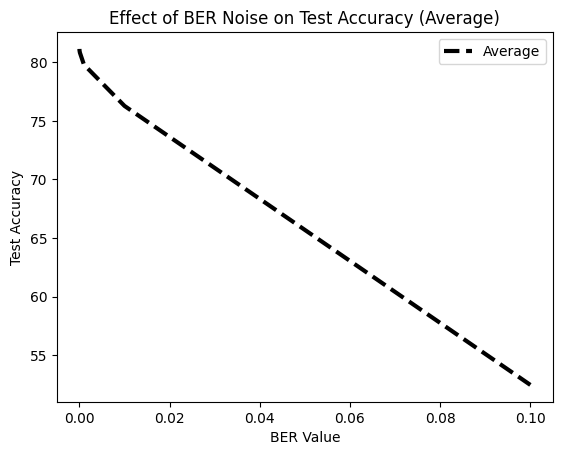

<Figure size 640x480 with 0 Axes>

In [61]:
def ber_noise_plot_brevitas(num_perturbations, layer_names, ber_vector, model, device):
    
    if not os.path.exists("noise_plots_brevitas/ber_noise/"):
        os.makedirs("noise_plots_brevitas/ber_noise/")
    
    plt.style.use('default')
    
    all_test_accs = []

    for layer in layer_names:
        test_accs = []
        
        for ber in ber_vector:
            noisy_models = add_digital_noise_to_model_brevitas(model, [layer], ber, num_perturbations)
            
            accuracies = []
            
            for noisy_model in noisy_models:
                
                noisy_model.to(device)
                accuracies.append(test(noisy_model, test_quantized_loader, device))
                
            avg_accuracy = sum(accuracies) / len(accuracies)
            
            test_accs.append(avg_accuracy)
            
            print("BER Value: {}\tAverage Accuracy: {}".format(ber, avg_accuracy))
            
        all_test_accs.append(test_accs)
        
        plt.plot(ber_vector, test_accs,
                 label='{} Accuracy at Different Perturbation Levels'.format(layer))
        
        plt.xlabel('Standard Deviation')
        plt.ylabel('Test Accuracy')
        plt.title('Effect of Noise on Test Accuracy')
        plt.legend()
        plt.savefig("noise_plots_brevitas/ber_noise/{}.png".format(layer))
        plt.clf()
        print('Done with Plot {}'.format(layer))
        
    avg_test_accs = [sum(x) / len(x) for x in zip(*all_test_accs)]
    
    plt.plot(ber_vector, avg_test_accs, label='Average',
             linewidth=3, linestyle='--', color="black")
    
    plt.xlabel('BER Value')
    
    plt.ylabel('Test Accuracy')
    
    plt.title('Effect of BER Noise on Test Accuracy (Average)')
    
    plt.legend()
    plt.savefig("noise_plots_brevitas/ber_noise/average.png")
    plt.clf()
    
    
ber_noise_plot_brevitas(1, ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'fc1', 'fc2'], model, device)

In [66]:
def mask_noise_plots_brevitas(num_perturbations, layer_names, p_vals, gamma_vals, model, device):
    if not os.path.exists("noise_plots_brevitas/mask/"):
        os.makedirs("noise_plots_brevitas/mask")
        
    plt.style.use('default')
    
    # Create a list to store the test accuracies for all layers
    all_test_accs = []
    
    # Loop over each layer
    for layer in layer_names:
        # Initialize a list to store the test accuracies for this layer
        test_accs = []
        
        # Iterate over p_values and gamma_values
        for p in p_values:
            for gamma in gamma_values:
                
                # Add noise to the model for the defined layer only
                noisy_models = add_mask_to_model_brevitas(
                    model, [layer], p, gamma, num_perturbations)
                accuracies = []
                
                # Test the accuracy of each noisy model and append the result to the accuracies list
                for noisy_model in noisy_models:
                    # Move the model back to the target device
                    noisy_model.to(device)
                    accuracies.append(test(noisy_model, test_quantized_loader, device))
                
                # Calculate the average accuracy and print the result
                avg_accuracy = sum(accuracies) / len(accuracies)
                test_accs.append(avg_accuracy)
                print("Layer: {}, p: {}, gamma: {}, Average Accuracy: {}%".format(
                    layer, p, gamma, avg_accuracy))
        
        # Store the test accuracies for this layer in the all_test_accs list
        all_test_accs.append(test_accs)
    
    # Define the grid for p_values and gamma_values
    p_grid, gamma_grid = np.meshgrid(p_values, gamma_values)
    
    for i, layer in enumerate(layer_names):
        # Reshape test_accs list into a matrix
        test_accs_matrix = np.reshape(all_test_accs[i], (len(p_values), len(gamma_values)))
    
        # Create heatmap for the current layer
        plt.figure()
        plt.imshow(test_accs_matrix, cmap='viridis', origin='lower',
                   extent=(p_values[0], p_values[-1], gamma_values[0], gamma_values[-1]),
                   aspect='auto')
        plt.colorbar(label='Test Accuracy')
        plt.xlabel('P value')
        plt.ylabel('Gamma value')
        plt.title(f'Effect of Mask on Test Accuracy for {layer}')
        plt.savefig(f"noise_plots_brevitas/mask/{layer}.png")
        plt.clf()
    
    # Compute the average test accuracy across all layers for each p and gamma value
    avg_test_accs = np.mean(all_test_accs, axis=0)
    avg_test_accs_matrix = np.reshape(avg_test_accs, (len(p_values), len(gamma_values)))
    
    # Create heatmap for the average test accuracy
    plt.figure()
    plt.imshow(avg_test_accs_matrix, cmap='viridis', origin='lower',
               extent=(p_values[0], p_values[-1], gamma_values[0], gamma_values[-1]),
               aspect='auto')
    plt.colorbar(label='Test Accuracy')
    plt.xlabel('P value')
    plt.ylabel('Gamma Value')
    plt.title('Effect of Mask on Test Accuracy (Average)')
    plt.savefig("noise_plots_brevitas/mask/average.png")
    plt.show()
    plt.clf()
    
    
    # Begin Scatter Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the grid for p_values and gamma_values
    p_grid, gamma_grid = np.meshgrid(p_values, gamma_values)
    
    for i, layer in enumerate(layer_names):
        # Reshape test_accs list into a matrix
        test_accs_matrix = np.reshape(all_test_accs[i], (len(p_values), len(gamma_values)))
        
        # Flatten the matrices
        pvals_mesh = p_grid.flatten()
        gammavals_mesh = gamma_grid.flatten()
        layer_indices_mesh = np.full_like(pvals_mesh, i)  # create an array of layer indices
        
        # Scatter plot with layer indices, pvals, gammavals, and corresponding test accuracies
        c_array = np.array(test_accs_matrix).flatten()
        scatter = ax.scatter(layer_indices_mesh, pvals_mesh, gammavals_mesh, c=c_array, cmap='viridis', marker='o', s=60)
    
    # Customize the plot
    ax.set_xlabel('Layer index')
    ax.set_ylabel('P value')
    ax.set_zlabel('Gamma value')
    ax.set_xticks(np.arange(len(layer_names)))
    ax.set_xticklabels(layer_names)
    
    # Add color bar to the plot
    cbar = fig.colorbar(scatter, ax=ax, label='Test Accuracy')
    
    # Save and show the plot
    plt.savefig("noise_plots_brevitas/mask/scatter_plot.png")
    plt.show()

In [68]:
mask_noise_plots_brevitas(1, ['layer1', 'layer2', 'layer3', 'layer4', 'layer5'], p_vals, gamma_vals, model, device)

C:\Users/ashin/source/repos/Cifar10_Pytorch_NoiseAnalysis/Cifar10_Pytorch_NoiseAnalysis/pynq-finn-FPGA/noise_weight_analysis/utils\noise_functions.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Layer: layer1, p: 0.0, gamma: 0.0, Average Accuracy: 10.0%
Layer: layer1, p: 0.0, gamma: 0.2, Average Accuracy: 10.0%
Layer: layer1, p: 0.0, gamma: 0.4, Average Accuracy: 10.0%
Layer: layer1, p: 0.0, gamma: 0.6000000000000001, Average Accuracy: 10.0%
Layer: layer1, p: 0.0, gamma: 0.8, Average Accuracy: 10.0%


KeyboardInterrupt: 

In [76]:
from noise_functions import add_gaussian_noise

def add_gaussian_noise_to_model_brevitas(model, layer_names, sigma, num_perturbations):
    modified_models = []
    for _ in range(num_perturbations):
        modified_model = deepcopy(model)
        # add noise to the modified model
        for layer_name in layer_names:
            layer = getattr(modified_model, layer_name)
            with torch.no_grad():
                # Get the weight and bias tensors
                weight = layer.weight.cpu().detach().numpy()
                bias = layer.bias.cpu().detach().numpy() if layer.bias is not None else None
                # Add noise to the weight and bias tensors
                noised_weight = add_gaussian_noise(weight, sigma)
                if bias is not None:
                    noised_bias = add_gaussian_noise(bias, sigma)
                # Update the layer's weight and bias tensors with the noised values
                layer.weight = torch.nn.Parameter(
                    torch.tensor(noised_weight, dtype=torch.float))
                if bias is not None:
                    layer.bias = torch.nn.Parameter(
                        torch.tensor(noised_bias, dtype=torch.float))

        modified_models.append(modified_model)

    return modified_models

def gaussian_noise_plots_brevitas(num_perturbations, layer_names, sigma_vector, model, device):
    
    if not os.path.exists("noise_plots_brevitas/gaussian_noise/"):
        os.makedirs("noise_plots_brevitas/gaussian_noise/")
    
    plt.style.use('default')
    
    
    # Create a list to store the test accuracies for all layers
    all_test_accs = []
    
    # Loop over each layer and plot the test accuracy as a function of the standard deviation for that layer
    for layer in layer_names:
        # Initialize a list to store the test accuracies for this layer
        test_accs = []
        # Iterate over the standard deviation values and add noise to the model for this layer only
        for sigma in sigma_vector:
            # Add noise to the model for the defined layer only
            noisy_models = add_gaussian_noise_to_model_brevitas(
                model, [layer], sigma, num_perturbations)
            accuracies = []
            # Test the accuracy of each noisy model and append the result to the accuracies list
            for noisy_model in noisy_models:
                # Move the model back to the target device
                noisy_model.to(device)
                accuracies.append(test(noisy_model, test_quantized_loader, device))
            # Calculate the average accuracy and print the result
            avg_accuracy = sum(accuracies) / len(accuracies)
            # Append the average accuracy to the test_accs list
            test_accs.append(avg_accuracy)
            print("Sigma Value: {}, Average Accuracy: {}%".format(
                sigma, avg_accuracy))
        # Store the test accuracies for this layer in the all_test_accs list
        all_test_accs.append(test_accs)
        # Plot the test accuracies as a function of the standard deviation for this layer
        plt.plot(sigma_vector, test_accs,
                 label='{} Accuracy at Different Perturbation Levels'.format(layer))
        plt.xlabel('Standard Deviation')
        plt.ylabel('Test Accuracy')
        plt.title('Effect of Noise on Test Accuracy')
        plt.legend()
        plt.savefig("noise_plots_brevitas/gaussian_noise/{}.png".format(layer))
        plt.clf()
        print('Done with Plot {}'.format(layer))
    # Compute the average test accuracy across all layers for each standard deviation value
    avg_test_accs = [sum(x) / len(x) for x in zip(*all_test_accs)]
    # Plot the averaged test accuracies as a function of the standard deviation
    plt.plot(sigma_vector, avg_test_accs, label='Average',
             linewidth=3, linestyle='--', color="black")
    plt.xlabel('Standard Deviation')
    plt.ylabel('Test Accuracy')
    plt.title('Effect of Noise on Test Accuracy (Average)')
    plt.legend()
    plt.savefig("noise_plots_brevitas/gaussian_noise/average.png")
    plt.show()
    plt.clf()
    

In [ ]:
gaussian_noise_plots_brevitas(1, ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'fc1', 'fc2'], np.linspace(0, 0.2, 11), model, device)

Sigma Value: 0.0, Average Accuracy: 81.18%
Sigma Value: 0.02, Average Accuracy: 80.63%
Sigma Value: 0.04, Average Accuracy: 77.26%
Sigma Value: 0.06, Average Accuracy: 72.64%
Sigma Value: 0.08, Average Accuracy: 61.69%
Sigma Value: 0.1, Average Accuracy: 64.02%
Sigma Value: 0.12, Average Accuracy: 50.9%
Sigma Value: 0.14, Average Accuracy: 37.3%
Sigma Value: 0.16, Average Accuracy: 44.12%
Sigma Value: 0.18, Average Accuracy: 34.06%
Sigma Value: 0.2, Average Accuracy: 27.67%
Done with Plot layer1
Sigma Value: 0.0, Average Accuracy: 81.18%
Sigma Value: 0.02, Average Accuracy: 81.4%
Sigma Value: 0.04, Average Accuracy: 78.64%
Sigma Value: 0.06, Average Accuracy: 72.72%
Sigma Value: 0.08, Average Accuracy: 65.44%
Sigma Value: 0.1, Average Accuracy: 60.42%
Sigma Value: 0.12, Average Accuracy: 44.99%
